In [1]:
from __future__ import print_function

#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import seaborn as sns

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

def plot_pwm_2(pwm, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :
    
    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = 0.
    logo_height = 1.0
    
    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i]# * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if ii == 0 :
                dna_letter_at(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]]) * logo_height # * conservation[j]
                dna_letter_at(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, pwm.shape[0]))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            min(0., np.min(np.sum(pwm, axis=-1))) - 0.01 * np.max(np.abs(np.sum(pwm, axis=-1))),
            max(0., np.max(np.sum(pwm, axis=-1))) + 0.01 * np.max(np.abs(np.sum(pwm, axis=-1)))
        )
    
    print(np.min(np.sum(pwm, axis=-1)) - 0.1 * np.max(np.abs(np.sum(pwm, axis=-1))))
    print(np.max(np.sum(pwm, axis=-1)) + 0.1 * np.max(np.abs(np.sum(pwm, axis=-1))))
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

#One-hot-encoder
class SequenceEncoder :
    
    def __init__(self, encoder_type_id, encode_dims) :
        self.encoder_type_id = encoder_type_id
        self.encode_dims = encode_dims
    
    def encode(self, seq) :
        raise NotImplementedError()
    
    def encode_inplace(self, seq, encoding) :
        raise NotImplementedError()
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def decode(self, encoding) :
        raise NotImplementedError()
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def __call__(self, seq) :
        return self.encode(seq)
    
class OneHotEncoder(SequenceEncoder) :
    
    def __init__(self, seq_length, channel_map) :
        super(OneHotEncoder, self).__init__('onehot', (seq_length, len(channel_map)))
        
        self.seq_len = seq_length
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[self.n_channels - 1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)


Using TensorFlow backend.
2023-05-08 18:30:12.411112: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


2023-05-08 18:30:14.732147: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2023-05-08 18:30:14.734010: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c4aee99220 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-08 18:30:14.734040: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-08 18:30:14.736389: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-05-08 18:30:14.888467: E tensorflow/stream_executor/cuda/cuda_driver.cc:322] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-08 18:30:14.888530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (johannes-design-interpret-1): /proc/driver/nvidia/version does not exist


In [2]:
#Load APARENT2 model

import os

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, LocallyConnected2D, Conv1D, MaxPooling1D, LocallyConnected1D, LSTM, ConvLSTM2D, BatchNormalization
from keras.layers import Concatenate, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=False)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=False)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def load_residual_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_conv_0')
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='aparent_skip_add')
    
    final_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_final_conv')
    
    extend_tensor = Lambda(lambda x: K.concatenate([x[0], x[1][..., None, None]], axis=2), name='aparent_extend_tensor')
    
    expand_lib = Lambda(lambda x: K.tile(K.expand_dims(K.expand_dims(x, axis=1), axis=2), (1, 1, 206, 1)), name='aparent_expand_lib')
    
    lib_conv = LocallyConnected2D(1, (1, 1), strides=(1, 1), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='aparent_lib_conv')
    
    lib_add = Lambda(lambda x: x[0] + x[1], name='aparent_lib_add')
    
    def _net_func(sequence_input, lib_input, dummy_input) :
        conv_0_out = conv_0(sequence_input)

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_out = extend_tensor([final_conv(skip_add_out), dummy_input])
        
        #Add library bias
        lib_conv_out = lib_add([final_conv_out, lib_conv(expand_lib(lib_input))])
        
        return lib_conv_out

    return _net_func

def get_kl_divergence() :
    
    def kl_divergence(inputs) :
        y_true, y_pred, counts = inputs
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())

        return K.sum(y_true * K.log(y_true / y_pred), axis=-1)
    
    return kl_divergence

def get_sigmoid_kl_divergence() :
    
    def sigmoid_kl_divergence(inputs) :
        y_true, y_pred, counts = inputs
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
        return K.sum(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
    
    return sigmoid_kl_divergence

def load_aparent_model() :
    
    #APARENT parameters
    seq_input_shape = (1, 205, 4)
    lib_input_shape = (13,)
    num_outputs_iso = 1
    num_outputs_cut = 206
    
    #Plasmid model definition
    
    #Resnet function
    resnet = load_residual_network(
        n_groups=7,
        n_resblocks_per_group=4,
        n_channels=32,
        window_size=3,
        dilation_rates=[1, 2, 4, 8, 4, 2, 1],
        drop_rate=0.0
    )

    #Inputs
    seq_input = Input(shape=seq_input_shape)
    lib_input = Input(shape=lib_input_shape)
    dummy_input = Input(shape=(1,))
    plasmid_count = Input(shape=(1,))

    #Outputs
    true_iso = Input(shape=(num_outputs_iso,))
    true_cut = Input(shape=(num_outputs_cut,))

    cut_score = resnet(seq_input, lib_input, dummy_input)

    cut_prob = Lambda(lambda x: K.softmax(x[:, 0, :, 0], axis=-1))(cut_score)
    iso_prob = Lambda(lambda cl: K.expand_dims(K.sum(cl[:, 80:80+30], axis=-1), axis=-1))(cut_prob)

    plasmid_model = Model(
        inputs=[
            seq_input,
            lib_input,
            dummy_input
        ],
        outputs=[
            iso_prob,
            cut_prob
        ]
    )

    #Loss model definition
    sigmoid_kl_divergence = get_sigmoid_kl_divergence()
    kl_divergence = get_kl_divergence()
    
    plasmid_loss_iso = Lambda(sigmoid_kl_divergence, output_shape = (1,))([true_iso, iso_prob, plasmid_count])
    plasmid_loss_cut = Lambda(kl_divergence, output_shape = (1,))([true_cut, cut_prob, plasmid_count])

    total_loss = Lambda(
        lambda l: 0.5 * l[0] + 0.5 * l[1],
        output_shape = (1,)
    )(
        [
            plasmid_loss_iso,
            plasmid_loss_cut
        ]
    )

    loss_model = Model([
        seq_input,
        lib_input,
        dummy_input,
        plasmid_count,
        true_iso,
        true_cut
    ], total_loss)

    return [ ('plasmid_iso_cut_resnet', plasmid_model), ('loss', loss_model) ]

#Make new model with scalar isoform logit output
proximal_start = 77
proximal_end = 127

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode_no_drop'

save_dir = os.path.join(os.getcwd(), '../Keratinocyte_samples')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_aparent_model()[0][1]
aparent_model.load_weights(model_path, by_name=True)

#Re-define model for total isoform attribution
seq_input = Input(name="seq_input", shape=(1, 205, 4))
l_input = Input(name="l_input", shape=(13,))
dummy_input = Input(name="dummy_input", shape=(1,))

seq_cut = aparent_model([seq_input, l_input, dummy_input])[1]

def _lor(cuts_ref, iso_start=proximal_start, iso_end=proximal_end) :

    y_ref = K.sum(cuts_ref[:, iso_start:iso_end], axis=-1)[:, None]
    y_ref = K.clip(y_ref, K.epsilon(), 1.0 - K.epsilon())
    
    lor = K.log(y_ref / (1. - y_ref))

    return lor

lor_pred = Lambda(_lor, name='lor')(seq_cut)

aparent = Model(
    inputs=[seq_input, l_input, dummy_input],
    outputs=[lor_pred]
)

aparent.trainable = False

aparent.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:

df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

save_dict = np.load("polyadb_features_pas_3_utr3_perturb.npz")
x, m, l, c, y = save_dict['x'], save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y']

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))


x.shape = (5267, 10, 205, 4)
m.shape = (5267, 10)
l.shape = (5267, 10)
c.shape = (5267, 10, 28)
y.shape = (5267, 10, 28)


In [4]:
#Cache/Load APARENT2 baseline score

#np.save("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores", s)
s = np.load("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores.npy")

print(s.shape)


(5267, 10)


In [5]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i:i+1, dist_index[i], :])

y_dist = np.concatenate(y_dist, axis=0)

print(y_dist.shape)


(5267, 28)


In [6]:
#Load tissue-specific PAS model and generate scores for select tissue types

subset_cell_types = np.array([
    'NT',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'FIP1L1',
    'NUDT21',
    'RBBP6',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

subset_cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(subset_cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [7]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [8]:
#PAS network definition

import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv1D, LocallyConnected1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

def load_pas_network(n_cell_types=1, n_dil=6, n_channels=32, filter_size=3, filter_size_0=5, nonneg_up_to=0) :
    
    conv_0 = Conv2D(n_channels, kernel_size=(1, filter_size_0), kernel_constraint=keras.constraints.NonNeg() if nonneg_up_to > 0 else None, padding='same', activation='relu', name='pasnet_conv2d_0')
    
    drop_0 = Dropout(0.5, name='pasnet_drop_0')
    
    convs = [
        Conv2D(n_channels, kernel_size=(1, filter_size), kernel_constraint=keras.constraints.NonNeg() if i < nonneg_up_to else None, padding='same', activation='relu', dilation_rate=2**i, name='pasnet_conv2d_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    drops = [
        Dropout(0.5, name='pasnet_drop_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    adds = [
        Lambda(lambda x: x[0] + x[1], name='pasnet_add_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    pool = Lambda(lambda x: K.mean(x, axis=(1, 2)))

    final_dense = Dense(n_cell_types*3, activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='pasnet_dense_2')
    final_reshape = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], n_cell_types, 3)))
    
    def _net_func(sequence_input) :
        
        x = drop_0(conv_0(sequence_input))

        for i in range(1, n_dil+1):
            x = adds[i-1]([drops[i-1](convs[i-1](x)), x])

        pool_out = pool(x)

        final_dense_out = final_dense(pool_out)
        
        return final_reshape(final_dense_out)

    return _net_func

def _load_pas_model(model_name, n_cell_types=1) :
    
    seq_input = Input(shape=(1, 205, 4), name='seq_input')
    
    pas_net = load_pas_network(n_cell_types=n_cell_types)
    
    pred_output = pas_net(seq_input)
    
    pas_model = Model(seq_input, pred_output)
    pas_model.load_weights(model_name, by_name=True)
    pas_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(0.1))
    
    return pas_model

def _predict_multi_pas(pas_model, x, batch_size=32) :
    
    y_preds = []
    for k in range(x.shape[1]) :
        y_preds.append(pas_model.predict(x=[x[:, k:k+1, ...]], batch_size=32)[:, None, ...])
    
    return np.concatenate(y_preds, axis=1)


In [9]:
#Model parameters

n_bootstraps = 5
n_cell_types = subset_cell_types.shape[0]


In [10]:
#Predict tissue model scores

tissue_models = [
    _load_pas_model("saved_models/perturb_resnet_utr3_covar_drop_ensemble_" + str(bootstrap_ix) + "_pas_model.h5", n_cell_types=n_cell_types) for bootstrap_ix in range(n_bootstraps)
]
'''
ts_ensemble = np.concatenate([_predict_multi_pas(tissue_models[bootstrap_ix], x, batch_size=32)[..., None] for bootstrap_ix in range(n_bootstraps)], axis=-1)

ts = np.mean(ts_ensemble, axis=-1)

print("ts.shape = " + str(ts.shape))
'''

'\nts_ensemble = np.concatenate([_predict_multi_pas(tissue_models[bootstrap_ix], x, batch_size=32)[..., None] for bootstrap_ix in range(n_bootstraps)], axis=-1)\n\nts = np.mean(ts_ensemble, axis=-1)\n\nprint("ts.shape = " + str(ts.shape))\n'

In [11]:
#Cache/Load tissue scores
'''
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble", ts_ensemble)
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts", ts)
'''
ts_ensemble = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble.npy")
ts = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts.npy")

print(ts_ensemble.shape)
print(ts.shape)


(5267, 10, 11, 3, 5)
(5267, 10, 11, 3)


In [12]:
#Compute normalization statistics

cell_type_ixs = [cell_type_dict[ct] for ct in subset_cell_types.tolist()]

flat_x = np.reshape(x, (x.shape[0] * x.shape[1], 1, 205, 4))
flat_ts_ensemble = np.reshape(ts_ensemble, (x.shape[0] * x.shape[1], n_cell_types, n_bootstraps, 3))
flat_ts = np.reshape(ts, (x.shape[0] * x.shape[1], n_cell_types, 3))
flat_y = np.reshape(y[:, :, cell_type_ixs], (x.shape[0] * x.shape[1], n_cell_types))
flat_gene_ind = np.reshape(np.tile(np.arange(x.shape[0])[:, None], (1, x.shape[1])), (x.shape[0] * x.shape[1],))
flat_pas_ind = np.reshape(np.tile(np.arange(x.shape[1])[None, :], (x.shape[0], 1)), (x.shape[0] * x.shape[1],))

flat_m = np.reshape(m, (x.shape[0] * x.shape[1],))
flat_dist_mask = np.reshape(dist_mask, (x.shape[0] * x.shape[1],))

flat_keep_index = np.nonzero(flat_m >= 1)[0]

flat_x = flat_x[flat_keep_index, ...]
flat_ts_ensemble = flat_ts_ensemble[flat_keep_index, ...]
flat_ts = flat_ts[flat_keep_index, ...]
flat_y = flat_y[flat_keep_index, ...]
flat_gene_ind = flat_gene_ind[flat_keep_index, ...]
flat_pas_ind = flat_pas_ind[flat_keep_index, ...]

flat_m = flat_m[flat_keep_index, ...]
flat_dist_mask = flat_dist_mask[flat_keep_index, ...]


In [13]:
#Construct masks for proximal/middle/distal sites

flat_prox_mask = np.array((flat_pas_ind == 0), dtype=np.float32)
flat_middle_mask = 1. - flat_dist_mask - flat_prox_mask

flat_masks = [
    flat_prox_mask,
    flat_middle_mask,
    flat_dist_mask
]


In [14]:
#Load processed (flattened) PAS IDs from original dataframe

flat_ids = np.load("polyadb_features_pas_3_utr3_perturb_flat_ids.npy", allow_pickle=True)

#Compile and flatten gene names
flat_gene_names = []
for _, row in df.iterrows() :
    flat_gene_names.extend([row['gene'] for k in range(m.shape[1]) if row['pas_exists_' + str(k)] == 1])

flat_gene_names = np.array(flat_gene_names, dtype=object)


In [15]:
#Re-load gated importance scores

flat_scores = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_flat_g_scores.npy")
flat_scores = np.tile(flat_scores, (1, 1, 1, 1, 1, 4)) * flat_x[None, None, ...]

print("flat_scores.shape = " + str(flat_scores.shape))

#Re-load gated importance scores (bootstrap replicates)

n_bootstraps = 3

flat_scores_ensemble = []

for bootstrap_ix in range(n_bootstraps) :
    flat_scores_curr = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_flat_g_scores_bootstrap_" + str(bootstrap_ix) + ".npy")
    flat_scores_curr = np.tile(flat_scores_curr, (1, 1, 1, 1, 1, 4)) * flat_x[None, None, ...]
    
    flat_scores_ensemble.append(flat_scores_curr)
    
    print("(bootstrap_ix = " + str(bootstrap_ix) + ") flat_scores.shape = " + str(flat_scores_curr.shape))


flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 0) flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 1) flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 2) flat_scores.shape = (11, 3, 14764, 1, 205, 4)


In [16]:
#Get flat representation of sequences as dataframe

seqs = flat_x[:, 0, ...]

seqs_str = []
for i in range(seqs.shape[0]) :
    seq = ""
    for j in range(seqs.shape[1]) :
        if seqs[i, j, 0] == 1. :
            seq += "A"
        elif seqs[i, j, 1] == 1. :
            seq += "C"
        elif seqs[i, j, 2] == 1. :
            seq += "G"
        elif seqs[i, j, 3] == 1. :
            seq += "T"
    
    seqs_str.append(seq)

seqs_str = np.array(seqs_str, dtype=np.object)

df = pd.DataFrame({
    "gene" : flat_gene_names.tolist(),
    "pas_id" : flat_ids.tolist(),
    "seq" : seqs_str.tolist(),
})

print("len(df) = " + str(len(df)))


len(df) = 14764


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [17]:
#Code for combinatorially inserting motifs and storing these sequence samples

def _insert_sequences(save_prefix, df, cell_type_1_ix=0, cell_type_2_ix=1, pred_cell_type_2_ixs=None, score_ix=0, seq_start=0, seq_end=205, n_samples=5, distance_samples=[0, 5, 10], sim_motifs=['TGTA', 'TGTA'], sim_pos_funcs=[None, None]) :
    
    if pred_cell_type_2_ixs is None :
        pred_cell_type_2_ixs = [cell_type_2_ix]
    
    save_name = "epistasis_insert_" + save_prefix + "/cell_type_1_ix_" + str(cell_type_1_ix) + "_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(len(df))
    
    if not os.path.exists("./samples/" + save_name.split("/")[0]) :
        os.makedirs("./samples/" + save_name.split("/")[0])
    
    #Get sequence encoder
    acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})
    
    motif_1_seq, motif_2_seq = sim_motifs
    pos_1_func, pos_2_func = sim_pos_funcs

    motif_1_len = len(motif_1_seq)
    motif_2_len = len(motif_2_seq)

    poses_1 = pos_1_func(motif_1_len)
    poses_2 = pos_2_func(motif_2_len)

    #Sample insertion positions at specified distance offsets
    pos_pairs = []
    pos_pair_dict = {}
    for distance_sample in distance_samples :

        #Sample position 1's
        
        n_found = 0
        max_iter = 10000
        curr_iter = 0
        while n_found < n_samples :
            pos_1 = np.random.choice(poses_1)
        
            #Get list of valid position 2's
            pos_2_valids = []
            for pos_2_cand in poses_2 :
                if pos_2_cand > pos_1 and pos_2_cand - (pos_1 + motif_1_len) == distance_sample :
                    pos_2_valids.append(pos_2_cand)
                elif pos_2_cand < pos_1 and pos_1 - (pos_2_cand + motif_2_len) == distance_sample :
                    pos_2_valids.append(pos_2_cand)
            
            #Randomly sample among valid position 2's
            if len(pos_2_valids) > 0:
                pos_2 = np.random.choice(pos_2_valids)

                #Accumulate position pairs
                if str(pos_1) + "_" + str(pos_2) not in pos_pair_dict and str(pos_2) + "_" + str(pos_1) not in pos_pair_dict :
                    if pos_1 < pos_2 :
                        pos_pairs.append([pos_1, pos_2])
                    else :
                        pos_pairs.append([pos_2, pos_1])
                    
                    pos_pair_dict[str(pos_1) + "_" + str(pos_2)] = True
                    pos_pair_dict[str(pos_2) + "_" + str(pos_1)] = True
                
                    n_found += 1
            elif curr_iter > max_iter :
                print("Err, could not sample pos_2.")
                print("" + 1)
            
            curr_iter += 1
    
    #Save sequences to file
    with open("./samples/" + save_name + ".txt", "w") as f :
        
        diff_score_col_str = ""
        for pred_cell_type_2_ix in pred_cell_type_2_ixs :
            for sc_ix in range(3) :
                diff_score_col_str += "\tdiff_ct_" + str(pred_cell_type_2_ix) + "_score_" + str(sc_ix)
        
        f.write("gene_id\tpas_id\texperiment\tseq" + diff_score_col_str + "\n")
        
        for i, [_, row] in enumerate(df.iterrows()) :
            gene_id = row['gene']
            pas_id = row['pas_id']
            experiment = 'wt'
            wt_seq = row['seq'][seq_start:seq_end]
            
            wt_x = acgt_encoder.encode(wt_seq)[None, None, ...]
            
            pred_curr = []
            for bootstrap_ix in range(n_bootstraps) :
                pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                    wt_x
                ], batch_size=1, verbose=False))
            
            pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)
            
            diff_score_str = ""
            for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                for sc_ix in range(3) :
                    diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))
            
            #Store wildtype sequence
            f.write(gene_id + "\t" + pas_id + "\t" + experiment + "\t" + wt_seq + diff_score_str + "\n")
            
            pos_written_dict = {}
            
            #Loop over position pairs
            for pos_1, pos_2 in pos_pairs :
                
                #Construct sequence samples with inserted motif(s)
                inserted_seq_1 = wt_seq[:pos_1] + motif_1_seq + wt_seq[pos_1+motif_1_len:]
                inserted_seq_2 = wt_seq[:pos_2] + motif_2_seq + wt_seq[pos_2+motif_2_len:]
                inserted_seq_1_and_2 = wt_seq[:pos_1] + motif_1_seq + wt_seq[pos_1+motif_1_len:pos_2] + motif_2_seq + wt_seq[pos_2+motif_2_len:]
                
                ins_x_1 = acgt_encoder.encode(inserted_seq_1)[None, None, ...]
                ins_x_2 = acgt_encoder.encode(inserted_seq_2)[None, None, ...]
                ins_x_1_and_2 = acgt_encoder.encode(inserted_seq_1_and_2)[None, None, ...]

                #Get predictions for inserted sample 1
                pred_curr_1 = []
                for bootstrap_ix in range(n_bootstraps) :
                    pred_curr_1.append(tissue_models[bootstrap_ix].predict(x=[
                        ins_x_1
                    ], batch_size=1, verbose=False))

                pred_curr_1 = np.mean(np.concatenate(pred_curr_1, axis=0), axis=0)

                diff_score_str_1 = ""
                for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                    for sc_ix in range(3) :
                        diff_score_str_1 += "\t" + str(round(pred_curr_1[cell_type_1_ix, sc_ix] - pred_curr_1[pred_cell_type_2_ix, sc_ix], 4))

                #Get predictions for inserted sample 2
                pred_curr_2 = []
                for bootstrap_ix in range(n_bootstraps) :
                    pred_curr_2.append(tissue_models[bootstrap_ix].predict(x=[
                        ins_x_2
                    ], batch_size=1, verbose=False))

                pred_curr_2 = np.mean(np.concatenate(pred_curr_2, axis=0), axis=0)

                diff_score_str_2 = ""
                for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                    for sc_ix in range(3) :
                        diff_score_str_2 += "\t" + str(round(pred_curr_2[cell_type_1_ix, sc_ix] - pred_curr_2[pred_cell_type_2_ix, sc_ix], 4))
                
                #Get predictions for inserted sample 1 and 2
                pred_curr_1_and_2 = []
                for bootstrap_ix in range(n_bootstraps) :
                    pred_curr_1_and_2.append(tissue_models[bootstrap_ix].predict(x=[
                        ins_x_1_and_2
                    ], batch_size=1, verbose=False))

                pred_curr_1_and_2 = np.mean(np.concatenate(pred_curr_1_and_2, axis=0), axis=0)

                diff_score_str_1_and_2 = ""
                for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                    for sc_ix in range(3) :
                        diff_score_str_1_and_2 += "\t" + str(round(pred_curr_1_and_2[cell_type_1_ix, sc_ix] - pred_curr_1_and_2[pred_cell_type_2_ix, sc_ix], 4))
                
                #Store inserted samples
                if pos_1 not in pos_written_dict :
                    f.write(gene_id + "\t" + pas_id + "\t" + "insert_pos_" + str(pos_1) + "\t" + inserted_seq_1 + diff_score_str_1 + "\n")
                    pos_written_dict[pos_1] = True
                if pos_2 not in pos_written_dict :
                    f.write(gene_id + "\t" + pas_id + "\t" + "insert_pos_" + str(pos_2) + "\t" + inserted_seq_2 + diff_score_str_2 + "\n")
                    pos_written_dict[pos_2] = True
                
                f.write(gene_id + "\t" + pas_id + "\t" + "insert_pos_" + str(pos_1) + "_and_" + str(pos_2) + "\t" + inserted_seq_1_and_2 + diff_score_str_1_and_2 + "\n")

def _inspect_epistatis_insertion(experiment_prefix, n_sequences=25, cell_type_1_ix=0, cell_type_2_ix=6, score_ix=2, pred_cell_type_2_ix=6, motif_len=6, n_samples=5, epi_sign=1.) :

    df_ins = pd.read_csv("samples/epistasis_insert_" + experiment_prefix + "/cell_type_1_ix_0_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(n_sequences) + ".txt", sep='\t')

    #Specify cell type index to use for predictions
    df_ins['diff_score_0'] = df_ins['diff_ct_' + str(pred_cell_type_2_ix) + '_score_0']
    df_ins['diff_score_1'] = df_ins['diff_ct_' + str(pred_cell_type_2_ix) + '_score_1']
    df_ins['diff_score_2'] = df_ins['diff_ct_' + str(pred_cell_type_2_ix) + '_score_2']
    
    #Predict aparent2 scores
    def _predict_aparent2(seqs) :
        
        #Get sequence encoder
        acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})

        x = []
        for seq in seqs :
            x.append(
                acgt_encoder.encode(seq)[None, None, ...]
            )
        x = np.concatenate(x, axis=0)
        l = np.zeros((x.shape[0], 13))
        l[:, 11] = 1.
        d = np.zeros((x.shape[0], 1))
        a = aparent.predict(x=[x, l, d], batch_size=32)[:, 0]
        
        return a
    
    df_ins['aparent2_score'] = _predict_aparent2(df_ins['seq'].values.tolist())

    #Get wt dataframe
    df_ins_wt = df_ins.query("experiment == 'wt'").copy().reset_index(drop=True)

    #Get non-wt dataframes
    df_ins = df_ins.query("experiment != 'wt'").copy().reset_index(drop=True)

    #Augment with wt predictions
    df_ins = df_ins.join(df_ins_wt[['pas_id', 'seq', 'diff_score_0', 'diff_score_1', 'diff_score_2', 'aparent2_score']].set_index("pas_id"), on='pas_id', how='inner', rsuffix='_wt').copy().reset_index(drop=True)

    #Get insert_1 dataframe
    df_ins_1 = df_ins.loc[~df_ins['experiment'].str.contains("_and_")].copy().reset_index(drop=True)

    df_ins_1['pos'] = df_ins_1['experiment'].apply(lambda x: int(x.split("_pos_")[1]))
    df_ins_1['join_id'] = df_ins_1['pas_id'] + "_" + df_ins_1['pos'].astype(str)
    
    #Get insert_1_and_2 dataframe
    df_ins_1_and_2 = df_ins.loc[df_ins['experiment'].str.contains("_and_")].copy().reset_index(drop=True)

    df_ins_1_and_2['pos_1'] = df_ins_1_and_2['experiment'].apply(lambda x: int(x.split("_pos_")[1].split("_and_")[0]))
    df_ins_1_and_2['pos_2'] = df_ins_1_and_2['experiment'].apply(lambda x: int(x.split("_pos_")[1].split("_and_")[1]))
    
    df_ins_1_and_2['join_id_1'] = df_ins_1_and_2['pas_id'] + "_" + df_ins_1_and_2['pos_1'].astype(str)
    df_ins_1_and_2['join_id_2'] = df_ins_1_and_2['pas_id'] + "_" + df_ins_1_and_2['pos_2'].astype(str)
    
    print("len(df_ins_1_and_2) (unique) = " + str(np.unique((df_ins_1_and_2['pas_id'] + "_" + df_ins_1_and_2['experiment']).values).shape[0]))
    
    #Calculate final epistasis scores
    df_ins = df_ins_1_and_2.join(df_ins_1[['join_id', 'diff_score_0', 'diff_score_1', 'diff_score_2', 'aparent2_score']].set_index('join_id'), on='join_id_1', how='inner', rsuffix='_ins_1').copy().reset_index(drop=True)
    df_ins = df_ins.join(df_ins_1[['join_id', 'diff_score_0', 'diff_score_1', 'diff_score_2', 'aparent2_score']].set_index('join_id'), on='join_id_2', how='inner', rsuffix='_ins_2').copy().reset_index(drop=True)

    df_ins = df_ins.rename(columns={
        'aparent2_score' : 'aparent2_score_ins_1_and_2',
        'diff_score_0' : 'diff_score_0_ins_1_and_2',
        'diff_score_1' : 'diff_score_1_ins_1_and_2',
        'diff_score_2' : 'diff_score_2_ins_1_and_2',
    })

    for sc_ix in range(3) :
        df_ins['epi_score_' + str(sc_ix)] = epi_sign * ((df_ins['diff_score_' + str(sc_ix) + '_ins_1_and_2'] - df_ins['diff_score_' + str(sc_ix) + '_wt']) - ((df_ins['diff_score_' + str(sc_ix) + '_ins_1'] - df_ins['diff_score_' + str(sc_ix) + '_wt']) + (df_ins['diff_score_' + str(sc_ix) + '_ins_2'] - df_ins['diff_score_' + str(sc_ix) + '_wt'])))
    
    df_ins['aparent2_epi_score'] = ((df_ins['aparent2_score_ins_1_and_2'] - df_ins['aparent2_score_wt']) - ((df_ins['aparent2_score_ins_1'] - df_ins['aparent2_score_wt']) + (df_ins['aparent2_score_ins_2'] - df_ins['aparent2_score_wt'])))
    
    #Get motif scramble positions
    df_ins['pos_1'] = df_ins['experiment'].apply(lambda x: int(x.split("_pos_")[1].split("_and_")[0]))
    df_ins['pos_2'] = df_ins['experiment'].apply(lambda x: int(x.split("_pos_")[1].split("_and_")[1]))

    #Calculate motif distances
    df_ins['distance'] = np.abs(df_ins['pos_1'] - df_ins['pos_2']) - motif_len
    
    print("len(df_ins_wt) = " + str(len(df_ins_wt)))
    print("len(df_ins) = " + str(len(df_ins)))

    #Visualize epistatic scores as a function of motif distance
    
    n_wt = len(df_ins_wt)
    distances = sorted(df_ins['distance'].unique().tolist())
    
    epi_scores_by_distance = np.zeros((n_wt * n_samples, len(distances)))
    aparent2_epi_scores_by_distance = np.zeros((n_wt * n_samples, len(distances)))
    for distance_ix, distance in enumerate(distances) :
        epi_scores_by_distance[:, distance_ix] = df_ins.query("distance == " + str(distance))['epi_score_' + str(score_ix)].values
        aparent2_epi_scores_by_distance[:, distance_ix] = df_ins.query("distance == " + str(distance))['aparent2_epi_score'].values
    
    min_x = int(np.min(distances))
    max_x = int(np.max(distances))
    
    #Plot perturbation epi scores
    plot_area = True
    
    sim_color = 'red'
    
    f = plt.figure(figsize=(6, 4))

    x_vals = np.array(distances)
    
    y_vals_low = np.exp(np.quantile(epi_scores_by_distance, q=0.1, axis=0))
    y_vals = np.exp(np.median(epi_scores_by_distance, axis=0))
    y_vals_high = np.exp(np.quantile(epi_scores_by_distance, q=0.9, axis=0))

    if plot_area :
        plt.plot(x_vals, y_vals_low, color=sim_color, alpha=0.5, linewidth=2, linestyle='--')
        plt.plot(x_vals, y_vals_high, color=sim_color, alpha=0.5, linewidth=2, linestyle='--')
        plt.fill_between(x_vals, y_vals_low, y_vals_high, color=sim_color, alpha=0.25)

    plt.plot(x_vals, y_vals, color=sim_color, linewidth=2, linestyle='-')
    plt.scatter(x_vals, y_vals, s=25, color=sim_color)

    plt.axhline(y=1., linewidth=3, linestyle='--', color='black', alpha=0.75)

    plt.xlim(min_x-0.1, max_x+0.1)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Motif Distance (bp)", fontsize=12)
    plt.ylabel("Epistasis (odds ratio)", fontsize=12)

    plt.tight_layout()
    
    #Plot aparent2 epi scores
    plot_area = True
    
    sim_color = 'black'
    
    f = plt.figure(figsize=(6, 4))

    x_vals = np.array(distances)
    
    y_vals_low = np.exp(np.quantile(aparent2_epi_scores_by_distance, q=0.1, axis=0))
    y_vals = np.exp(np.median(aparent2_epi_scores_by_distance, axis=0))
    y_vals_high = np.exp(np.quantile(aparent2_epi_scores_by_distance, q=0.9, axis=0))

    if plot_area :
        plt.plot(x_vals, y_vals_low, color=sim_color, alpha=0.5, linewidth=2, linestyle='--')
        plt.plot(x_vals, y_vals_high, color=sim_color, alpha=0.5, linewidth=2, linestyle='--')
        plt.fill_between(x_vals, y_vals_low, y_vals_high, color=sim_color, alpha=0.25)

    plt.plot(x_vals, y_vals, color=sim_color, linewidth=2, linestyle='-')
    plt.scatter(x_vals, y_vals, s=25, color=sim_color)

    plt.axhline(y=1., linewidth=3, linestyle='--', color='black', alpha=0.75)

    plt.xlim(min_x-0.1, max_x+0.1)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Motif Distance (bp)", fontsize=12)
    plt.ylabel("APARENT2 Epi (odds ratio)", fontsize=12)

    plt.tight_layout()
    
    return df_ins


In [17]:
#Find sequences without wildtype TGTA motifs (multiple compositions tested)

n_wt = 10

df['n_tgta'] = df['seq'].str.slice(0, 70).str.count("TGTA")
df['cano_cse'] = df['seq'].str.slice(70, 76).str.contains("AATAAA|ATTAAA|AGTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 70).str.contains("AATAAA|ATTAAA")

df['A'] = df['seq'].str.slice(0, 70).str.count("A") / 70.
df['C'] = df['seq'].str.slice(0, 70).str.count("C") / 70.
df['G'] = df['seq'].str.slice(0, 70).str.count("G") / 70.
df['T'] = df['seq'].str.slice(0, 70).str.count("T") / 70.

df['gc_composition'] = (df['G'] + df['C'] >= 0.50) & (df['T'] <= 0.15)
df['at_composition'] = (df['A'] + df['T'] >= 0.70) & (df['G'] <= 0.10)

gc_wt_index = np.nonzero((((df['n_tgta'] == 0) & (df['cano_cse'] == 1)) & ((df['gc_composition'] == True) & (df['use_cse'] == 0))).values)[0]
at_wt_index = np.nonzero((((df['n_tgta'] == 0) & (df['cano_cse'] == 1)) & ((df['at_composition'] == True) & (df['use_cse'] == 0))).values)[0]

#Shuffle index positions
np.random.shuffle(gc_wt_index)
np.random.shuffle(at_wt_index)

df_wt_gc = df.iloc[gc_wt_index[:n_wt]].copy().reset_index(drop=True)
df_wt_at = df.iloc[at_wt_index[:n_wt]].copy().reset_index(drop=True)

print("len(df_wt_gc) = " + str(len(df_wt_gc)))
print("len(df_wt_at) = " + str(len(df_wt_at)))

sim_motifs = ["ATTGTA", "TGTAAT"]

sim_pos_funcs = [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()]


len(df_wt_gc) = 10
len(df_wt_at) = 10


In [23]:
#Store wt sequences and their inserted motif samples

#Parameter configuration
experiment_prefix = 'TGTA_AT_comp'

df_exp = df_wt_at

motif_len = 6

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ixs = [6]

_insert_sequences(
    experiment_prefix,
    df_exp,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    pred_cell_type_2_ixs=pred_cell_type_2_ixs,
    score_ix=score_ix,
    n_samples=5,
    distance_samples=[1, 3, 5, 10, 40],
    sim_motifs=sim_motifs,
    sim_pos_funcs=sim_pos_funcs
)


len(df_ins_1_and_2) (unique) = 250
len(df_ins_wt) = 10
len(df_ins) = 250


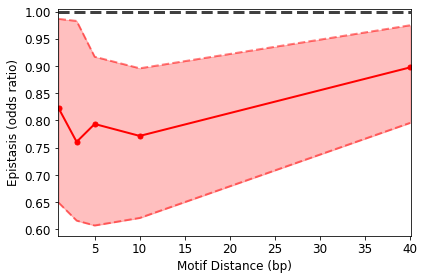

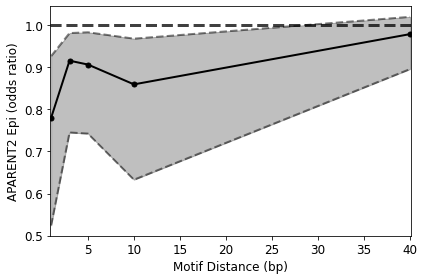

In [22]:
#Inspect epistasis insertion designs

experiment_prefix = 'TGTA_AT_comp'

n_sequences = 10

motif_len = 6

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ix = 6

n_samples = 5

df_ins = _inspect_epistatis_insertion(
    experiment_prefix,
    n_sequences=n_sequences,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    score_ix=score_ix,
    pred_cell_type_2_ix=pred_cell_type_2_ix,
    motif_len=motif_len,
    n_samples=n_samples,
)


In [27]:
#Store wt sequences and their inserted motif samples

#Parameter configuration
experiment_prefix = 'TGTA_GC_comp'

df_exp = df_wt_gc

motif_len = 6

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ixs = [6]

_insert_sequences(
    experiment_prefix,
    df_exp,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    pred_cell_type_2_ixs=pred_cell_type_2_ixs,
    score_ix=score_ix,
    n_samples=5,
    distance_samples=[1, 3, 5, 10, 40],
    sim_motifs=sim_motifs,
    sim_pos_funcs=sim_pos_funcs
)


len(df_ins_1_and_2) (unique) = 250
len(df_ins_wt) = 10
len(df_ins) = 250


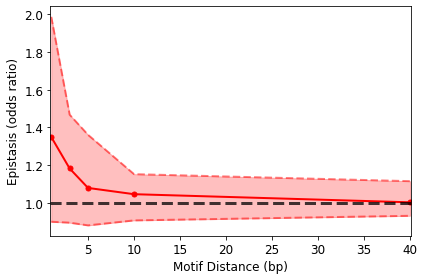

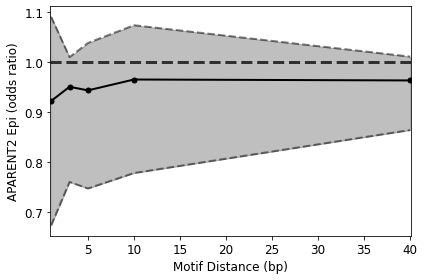

In [23]:
#Inspect epistasis insertion designs

experiment_prefix = 'TGTA_GC_comp'

n_sequences = 10

motif_len = 6

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ix = 6

n_samples = 5

df_ins = _inspect_epistatis_insertion(
    experiment_prefix,
    n_sequences=n_sequences,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    score_ix=score_ix,
    pred_cell_type_2_ix=pred_cell_type_2_ix,
    motif_len=motif_len,
    n_samples=n_samples,
)


In [51]:
#Find sequences without wildtype TGTA motifs (vary flanks)

n_wt = 10

df['n_tgta'] = df['seq'].str.slice(0, 70).str.count("TGTA")
df['cano_cse'] = df['seq'].str.slice(70, 76).str.contains("AATAAA|ATTAAA|AGTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 70).str.contains("AATAAA|ATTAAA")

df['A'] = df['seq'].str.slice(0, 70).str.count("A") / 70.
df['C'] = df['seq'].str.slice(0, 70).str.count("C") / 70.
df['G'] = df['seq'].str.slice(0, 70).str.count("G") / 70.
df['T'] = df['seq'].str.slice(0, 70).str.count("T") / 70.

wt_index = np.nonzero((((df['n_tgta'] == 0) & (df['cano_cse'] == 1)) & (df['use_cse'] == 0)).values)[0]

#Shuffle index positions
np.random.shuffle(wt_index)

df_wt = df.iloc[wt_index[:n_wt]].copy().reset_index(drop=True)

print("len(df_wt) = " + str(len(df_wt)))

sim_motifs_at = ["TTTGTAAT", "TTTGTAAT"]
sim_motifs_gc = ["GGTGTAGC", "GGTGTAGG"]

sim_pos_funcs = [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()]


len(df_wt) = 10


In [29]:
#Store wt sequences and their inserted motif samples

#Parameter configuration
experiment_prefix = 'TGTA_AT_flanks_v2'

df_exp = df_wt

motif_len = 10

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ixs = [6]

_insert_sequences(
    experiment_prefix,
    df_exp,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    pred_cell_type_2_ixs=pred_cell_type_2_ixs,
    score_ix=score_ix,
    n_samples=5,
    distance_samples=[0, 5, 10, 20, 40],
    sim_motifs=sim_motifs_at,
    sim_pos_funcs=sim_pos_funcs
)


len(df_ins_1_and_2) (unique) = 250
len(df_ins_wt) = 10
len(df_ins) = 250


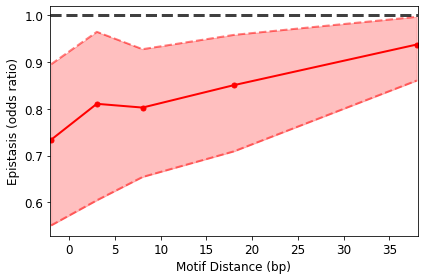

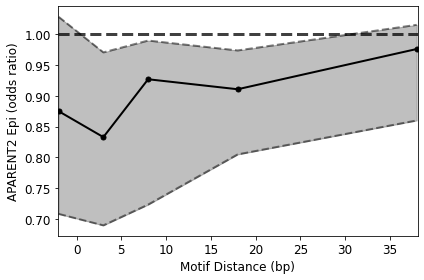

In [20]:
#Inspect epistasis insertion designs

experiment_prefix = 'TGTA_AT_flanks_v2'

n_sequences = 10

motif_len = 10

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ix = 6

n_samples = 5

df_ins = _inspect_epistatis_insertion(
    experiment_prefix,
    n_sequences=n_sequences,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    score_ix=score_ix,
    pred_cell_type_2_ix=pred_cell_type_2_ix,
    motif_len=motif_len,
    n_samples=n_samples,
)


In [32]:
#Store wt sequences and their inserted motif samples

#Parameter configuration
experiment_prefix = 'TGTA_GC_flanks_v2'

df_exp = df_wt

motif_len = 10

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ixs = [6]

_insert_sequences(
    experiment_prefix,
    df_exp,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    pred_cell_type_2_ixs=pred_cell_type_2_ixs,
    score_ix=score_ix,
    n_samples=5,
    distance_samples=[0, 5, 10, 20, 40],
    sim_motifs=sim_motifs_gc,
    sim_pos_funcs=sim_pos_funcs
)


len(df_ins_1_and_2) (unique) = 250
len(df_ins_wt) = 10
len(df_ins) = 250


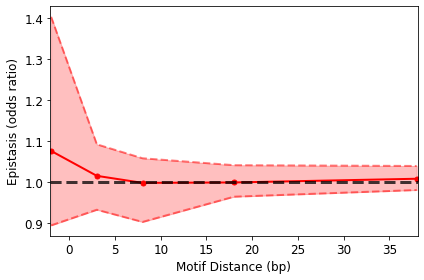

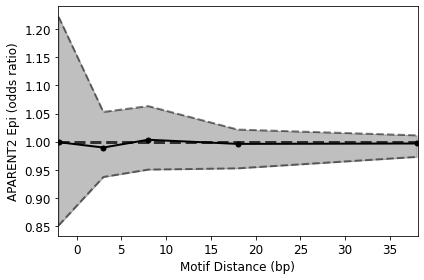

In [26]:
#Inspect epistasis insertion designs

experiment_prefix = 'TGTA_GC_flanks_v2'

n_sequences = 10

motif_len = 10

cell_type_1_ix = 0
cell_type_2_ix = 6

score_ix = 2

pred_cell_type_2_ix = 6

n_samples = 5

df_ins = _inspect_epistatis_insertion(
    experiment_prefix,
    n_sequences=n_sequences,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    score_ix=score_ix,
    pred_cell_type_2_ix=pred_cell_type_2_ix,
    motif_len=motif_len,
    n_samples=n_samples,
)


In [138]:
#Find sequences without wildtype GT-rich downstream motifs and a weak CSE

n_wt = 50

df['n_gt'] = df['seq'].str.slice(81, 121).str.count("GTG|TGT|GTCT|TGTC|TGTTGT|GTTT|TTTT|TTAT|GTTT|TTTG")
df['weak_cse'] = df['seq'].str.slice(70, 76).str.contains("ATTAAA|AGTAAA|ACTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 73).str.contains("AATAAA|ATTAAA")

wt_index = np.nonzero((((df['n_gt'] == 0) & (df['weak_cse'] == 1)) & (df['use_cse'] == 0)).values)[0]

#Shuffle index positions
np.random.shuffle(wt_index)

df_wt = df.iloc[wt_index[:n_wt]].copy().reset_index(drop=True)

print("len(df_wt) = " + str(len(df_wt)))

sim_motifs = ["AATAATAAATAA", "TTGTGTGTT"]

sim_pos_funcs = [lambda motif_1_len: [67], lambda motif_2_len: (np.arange(149-79) + 79).tolist()]


len(df_wt) = 50


In [139]:
#Store wt sequences and their inserted motif samples

#Parameter configuration
experiment_prefix = 'AWTAAA_GT'

df_exp = df_wt

cell_type_1_ix = 0
cell_type_2_ix = 7

score_ix = 2

pred_cell_type_2_ixs = [7]

_insert_sequences(
    experiment_prefix,
    df_exp,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    pred_cell_type_2_ixs=pred_cell_type_2_ixs,
    score_ix=score_ix,
    n_samples=1,
    distance_samples=[0, 5, 10, 20, 40],
    sim_motifs=sim_motifs,
    sim_pos_funcs=sim_pos_funcs,
)


len(df_ins_1_and_2) (unique) = 250
len(df_ins_wt) = 50
len(df_ins) = 250


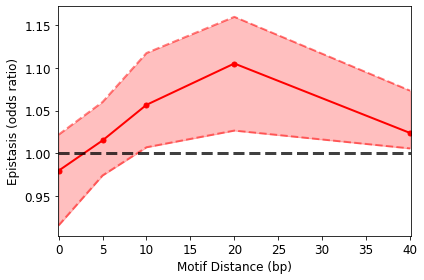

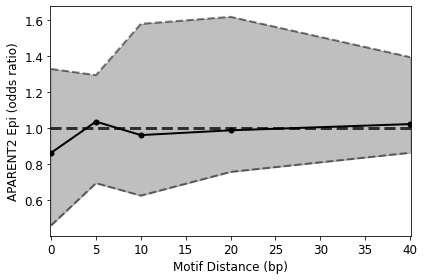

In [26]:
#Inspect epistasis insertion designs

experiment_prefix = 'AWTAAA_GT'

n_sequences = 50

motif_len = 12

cell_type_1_ix = 0
cell_type_2_ix = 7

score_ix = 2

pred_cell_type_2_ix = 7

n_samples = 1

df_ins = _inspect_epistatis_insertion(
    experiment_prefix,
    n_sequences=n_sequences,
    cell_type_1_ix=cell_type_1_ix,
    cell_type_2_ix=cell_type_2_ix,
    score_ix=score_ix,
    pred_cell_type_2_ix=pred_cell_type_2_ix,
    motif_len=motif_len,
    n_samples=n_samples,
    epi_sign = -1.
)
